<a href="https://colab.research.google.com/github/jvataidee/pdi_python/blob/main/classificacao_nao_supervisionada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Classificação Não Supervisionada

### Instalar e Importar bibliotecas

In [ ]:
!pip install spectral
!pip install rasterio

In [50]:
# Bibliotecas
from spectral import *
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans

from osgeo import gdal, ogr, osr

### IMportar Imagem

In [35]:
# Lendo imagem como array
src = rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/L71221071_07120010720_DN.tif')
b1 = src.read(1)
b2 = src.read(2)
b3 = src.read(3)
b4 = src.read(4)
b5 = src.read(5)
b7 = src.read(6)

img = np.dstack([b1,b2,b3,b4,b5,b7])

In [36]:
# Armazenando metadados
meta = src.profile

In [37]:
meta

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1520, 'height': 1233, 'count': 6, 'crs': CRS.from_epsg(32723), 'transform': Affine(30.0, 0.0, 160665.0,
       0.0, -30.0, 8279275.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

## Treinando modelo KMeans

In [38]:
# Rodando classificador
(classif, centros) = kmeans(img, 8, 30)

spectral:INFO: k-means iteration 1 - 1824922 pixels reassigned.
INFO:spectral:k-means iteration 1 - 1824922 pixels reassigned.
spectral:INFO: k-means iteration 2 - 85936 pixels reassigned.
INFO:spectral:k-means iteration 2 - 85936 pixels reassigned.
spectral:INFO: k-means iteration 3 - 67891 pixels reassigned.
INFO:spectral:k-means iteration 3 - 67891 pixels reassigned.
spectral:INFO: k-means iteration 4 - 91854 pixels reassigned.
INFO:spectral:k-means iteration 4 - 91854 pixels reassigned.
spectral:INFO: k-means iteration 5 - 93384 pixels reassigned.
INFO:spectral:k-means iteration 5 - 93384 pixels reassigned.
spectral:INFO: k-means iteration 6 - 86530 pixels reassigned.
INFO:spectral:k-means iteration 6 - 86530 pixels reassigned.
spectral:INFO: k-means iteration 7 - 80242 pixels reassigned.
INFO:spectral:k-means iteration 7 - 80242 pixels reassigned.
spectral:INFO: k-means iteration 8 - 78014 pixels reassigned.
INFO:spectral:k-means iteration 8 - 78014 pixels reassigned.
spectral:INF

Numero de centroides 8


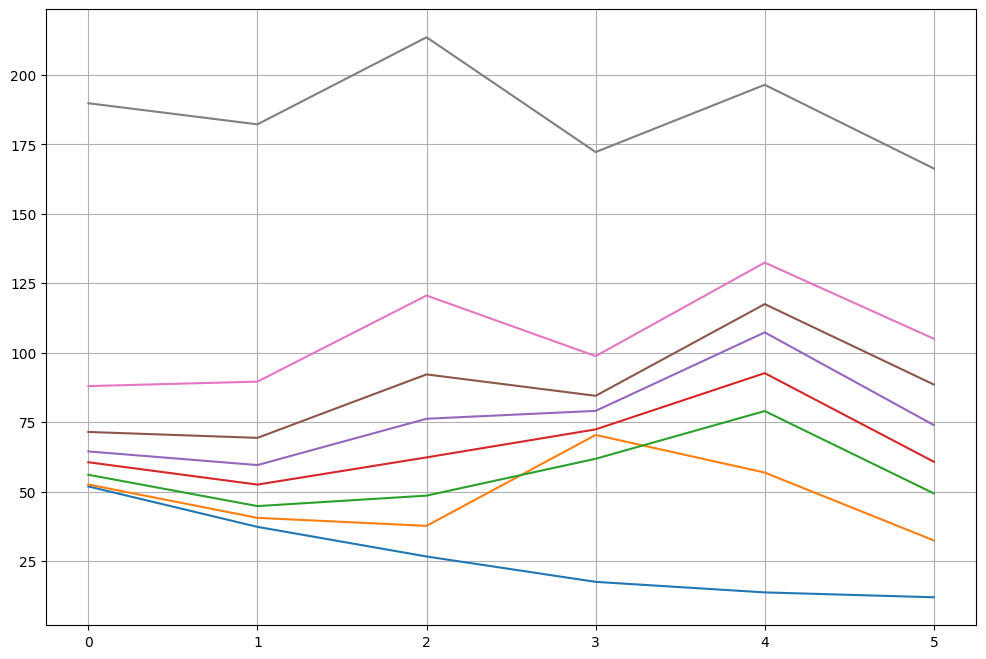

In [39]:
# Visualizando centróides em gráfico
print("Numero de centroides", centros.shape[0])
plt.figure(figsize = (12,8))
for i in range(centros.shape[0]):
  plt.plot(centros[i])
plt.grid()

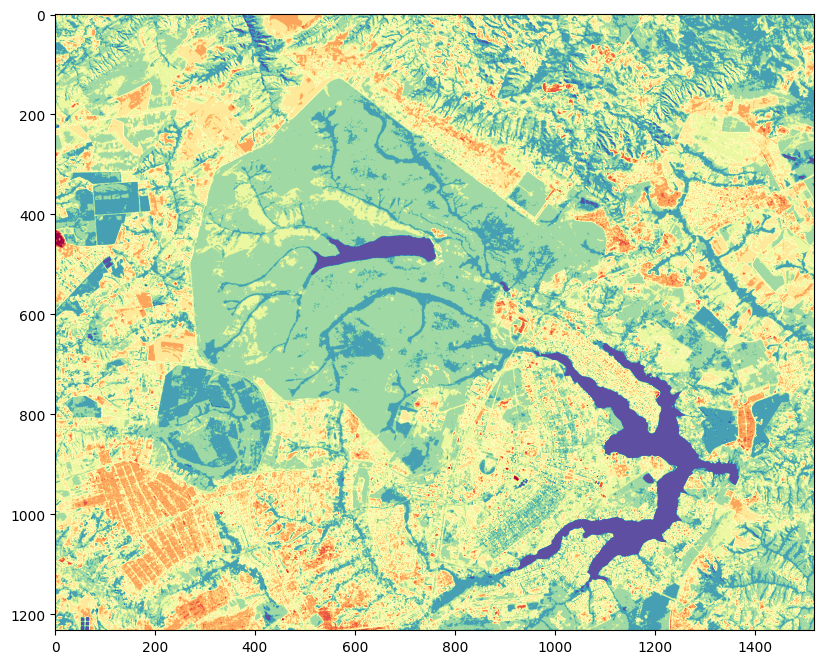

In [40]:
plt.figure(figsize = (20,8))
plt.imshow(classif, cmap='Spectral_r')
plt.show()

In [41]:
meta.update({'count':1})

In [42]:
# Salvando imagem classificada
with rio.open('kmeans.tif', 'w', **meta) as src:
  src.write(classif,1)

### Converter em Poligono

In [52]:
in_path = 'kmeans.tif'
out_path = 'kmeans.shp'

# Abrir o arquivo raster
src_ds = gdal.Open(in_path)

# Obter a banda do raster
srcband = src_ds.GetRasterBand(1)

# Nome da camada do shapefile de saída
dst_layername = 'cluster'

# Criar um driver para o shapefile
drv = ogr.GetDriverByName("ESRI Shapefile")

# Criar um novo data source para o shapefile
dst_ds = drv.CreateDataSource(out_path)

# Definir a referência espacial
sp_ref = osr.SpatialReference()
sp_ref.SetFromUserInput('EPSG:4326')

# Criar uma nova camada no shapefile
dst_layer = dst_ds.CreateLayer(dst_layername, srs=sp_ref)

# Definir o tipo de campo para a área
fld = ogr.FieldDefn("HA", ogr.OFTInteger)
dst_layer.CreateField(fld)

# Obter o índice do campo na camada
dst_field = dst_layer.GetLayerDefn().GetFieldIndex("HA")

# Executar a função Polygonize para converter o raster em polígonos
gdal.Polygonize(srcband, None, dst_layer, dst_field, [], callback=None)

# Fechar os data sources
del src_ds
del dst_ds


## Treinando modelo de Cluster

In [43]:
# Criando matrix com bandas em colunas
X = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

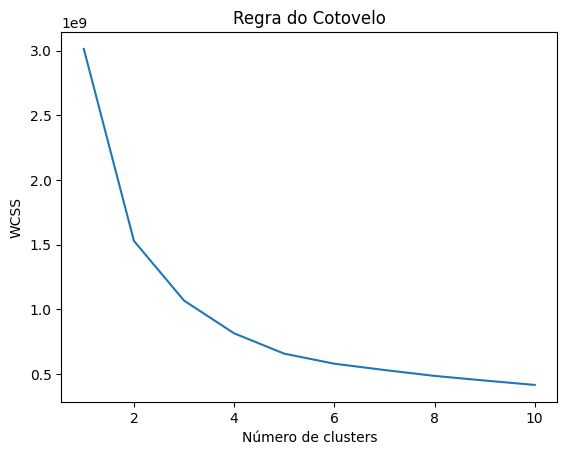

In [53]:
data = X

# Lista para armazenar os valores WCSS
wcss = []

# Número máximo de clusters a testar
max_clusters = 10

# Realizar análise de agrupamento para cada número de clusters
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Regra do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [54]:
n_clusters = 4

# Criando modelo
k_means = cluster.KMeans(n_clusters=n_clusters, max_iter=30)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:,:,0].shape)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


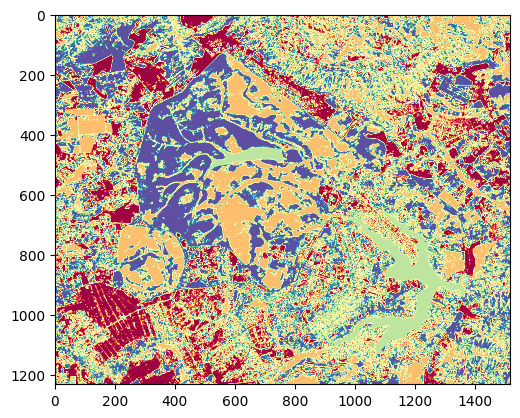

In [55]:
#Visualizando resultado
plt.imshow(X_cluster, cmap='Spectral')

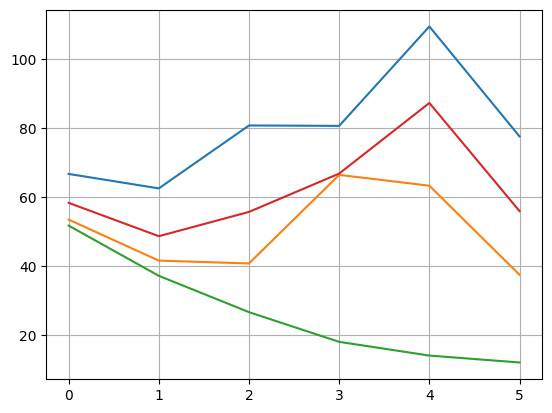

In [56]:
# Visualizando centróides
cent = k_means.cluster_centers_

plt.figure()
for i in range(cent.shape[0]):
  plt.plot(cent[i])

plt.grid()

In [57]:
# Salvando imagem classificada
with rio.open('kmeans2.tif', 'w', **meta) as src:
  src.write(X_cluster,1)